# <center>TP de fouille de données</center>
## <center>Détection et caractérisation de POI à Rennes<br> à partir des photos publiées sur Flickr</center>

<center>
2022-2023<br>
3INFO - Département Informatique - INSA Rennes<br> <br>
</center>

POI : point d'intérêt (Point of Interest). Pour ce TP nous considérons comme points d'intérêt les zones denses de photos publiées sur Flickr.

### Contributeurs à ce TP
- Francesco Bariatti
- Peggy Cellier (INSA Rennes)
- Ludovic Jean-Baptiste (Université de Caen)
- Mehdi Kaytoue (INSA Lyon)


# <font color=blue>Introduction</font>
## Objectifs du TP

L'objectif de ce TP est de trouver, à partir de données géolocalisées dans la ville de Rennes, les points d'intérêts de ses visiteurs (résidents, touristes, ...), au moyen d'une analyse spatiale non supervisée.
Un point d'intérêt est défini comme étant le lieu de photographies d'un grand nombre d'utilisateurs distincts.

**Vous n'avez pas à rendre le TP à la fin.**

## Jeu de données

Le jeu de données correspond aux photos présentes sur flickr et géolocalisées autour de Rennes en 2019.
[Flickr](https://www.flickr.com) est une plateforme en ligne qui permet à tout utilisateur de partager publiquement des photos contenant des informations variées comme un titre, des coordonnées géographiques ou bien encore des tags descriptifs des clichés.
L'objectif de ce TP est d'identifier des zones denses de photos publiées sur Flickr et de les considérer comme étant des zones d'intérêt (POI).

## Python et importation des bibliothèques utilisées pour le TP

Pour ce TP, Python 3 est utilisé ainsi que plusieurs bibliothèques qu'il faut charger :
1. **pandas** : permet de manipuler et d'analyser facilement des données  
https://pandas.pydata.org/pandas-docs/stable/
1. **numpy** : permet de manipuler efficacement des grandes matrices  
http://www.numpy.org
1. **sklearn** : offre un large choix d'algorithmes de fouille de données (mais peu d'algorithme de fouille de motifs) et d'analyse de données en général  
https://scikit-learn.org/stable/
1. **nltk** : permet de faire du traitement automatique des langues  
https://www.nltk.org
1. **mlxtend** : permet d'utiliser l'algorithme apriori  
http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
1. **matplotlib** : permet des affichages scientifiques sous la forme d'histogrammes, etc.  
https://matplotlib.org
1. **folium** : permet d'afficher des données géolocalisées sur une carte  
https://pypi.org/project/folium/
1. **re** (module de la bibliothèque standard python) : permet de manipuler des expressions régulières  
https://docs.python.org/3/library/re.html

In [1]:
# Vérification de la version de python
import sys
sys.version 

'3.5.2 (default, Nov 12 2018, 13:43:14) \n[GCC 5.4.0 20160609]'

In [2]:
# Import des modules nécessaires
import pandas as pd
import numpy as np
import sklearn.cluster
import nltk
import mlxtend
import matplotlib.pyplot as plt
import folium
import re

In [3]:
# La ligne suivantes permet d'importer les outils nécessaires pour utiliser l'aglorithme Apriori
from mlxtend.frequent_patterns import apriori

# Les lignes de code suivantes permettent d'importer une liste de stopwrds (ou mots vides)
# pour le français afin de les éliminer
nltk.download("stopwords")
from nltk.corpus import stopwords
stopwordslist = stopwords.words("french")
stopwordslist.append("NaN")

[nltk_data] Downloading package stopwords to /home-
[nltk_data]     reseau/pcellier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Constantes et variables utilisées dans le TP

In [4]:
LATITUDE, LONGITUDE = 48.117266, -1.6777926 # Latitude, longitude du centre de Rennes

# <font color=blue>Etape 1 : Préparation des données</font>

## Prise en main du jeu de données

Les informations concernant les photos sont stockées dans un fichier csv (`flickrRennes.csv`).
Pour manipuler aisément ces données nous les chargeons dans un `DataFrame` (structure de données de la bibliothèque pandas) directement à partir du fichier csv.

In [5]:
photos_orig = pd.read_csv("flickrRennes.csv")
photos = photos_orig.copy()

Affichage du tableau chargé :

In [6]:
photos.head()

id_photo                          title id_photographer        lat  \
0  47146974932                      Le Thabor   132905622@N08  48.114193   
1  46283874935  Ressort Rennes - atana studio    27111862@N06  48.099406   
2  46283874465      Action Joe - atana studio    27111862@N06  48.099406   
3  32256187777  Ressort Rennes - atana studio    27111862@N06  48.099406   
4  46474676184          Colors - atana studio    27111862@N06  48.099406   

       long                                          tags  \
0 -1.673054            rennes bretagne eglise parc thabor   
1 -1.671262  Ressort Rennes ATANA studio Anthony SÉJOURNÉ   
2 -1.671262      Action Joe ATANA studio Anthony SÉJOURNÉ   
3 -1.671262  Ressort Rennes ATANA studio Anthony SÉJOURNÉ   
4 -1.671262          Colors ATANA studio Anthony SÉJOURNÉ   

                                                 url        date_uploaded  \
0  https://www.flickr.com/photos/132905622@N08/47...  2019-02-24 18:35:30   
1  https://www.flickr.com/photos/atanastudio/4628...  2019-02-24 17:38:41   
2  https://www.flickr.com/photos/atanastudio/4628...  2019-02-24 17:38:42   
3  https://www.flickr.com/photos/atanastudio/3225...  2019-02-24 17:38:43   
4  https://www.flickr.com/photos/atanastudio/4647...  2019-02-24 17:38:43   

   date_uploaded_year  date_uploaded_month  date_uploaded_day  \
0                2019                    2                 24   
1                2019                    2                 24   
2                2019                    2                 24   
3                2019                    2                 24   
4                2019                    2                 24   

   date_uploaded_hour  date_uploaded_minutes           date_taken  \
0                  18                     35  2019-02-24 16:54:28   
1                  17                     38  2019-02-21 22:25:00   
2                  17                     38  2019-02-21 22:31:21   
3                  17                     38  2019-02-22 16:48:57   
4                  17                     38  2019-02-22 16:50:45   

   date_taken_year  date_taken_month  date_taken_day  date_taken_hour  \
0             2019                 2              24               16   
1             2019                 2              21               22   
2             2019                 2              21               22   
3             2019                 2              22               16   
4             2019                 2              22               16   

   date_taken_minutes  
0                  54  
1                  25  
2                  31  
3                  48  
4                  50

Description des colonnes :
- **id\_photo** = identifiant de la photo
- **title** = titre de la photo
- **id\_photographer** = identifiant du propriétaire de la photo (utilisateur qui a publié la photo)
- **lat, long** = coordonnées géographiques de la prise de vue
- **tags** = les tags fournis par l'utilisateur
- **url** = lien de la photo
- **date\_uploaded*** = champs avec informations sur la date de publication de la photo
- **date\_taken*** = champs avec informations sur la date de prise de la photo

<font color=orange>**Question** : *Affichez le nombre de photos contenues dans le DataFrame.*</font>

29541

<font color=orange>**Question** : *Affichez les valeurs moyennes et medianes de la latitude et longitude. Cela vous paraît-il cohérent ?*</font>

48.108595345892155
-1.6808699425544158
48.11011
-1.678194


id_photo                      title id_photographer        lat  \
2  46283874465  Action Joe - atana studio    27111862@N06  48.099406   

       long                                      tags  \
2 -1.671262  Action Joe ATANA studio Anthony SÉJOURNÉ   

                                                 url        date_uploaded  \
2  https://www.flickr.com/photos/atanastudio/4628...  2019-02-24 17:38:42   

   date_uploaded_year  date_uploaded_month  date_uploaded_day  \
2                2019                    2                 24   

   date_uploaded_hour  date_uploaded_minutes           date_taken  \
2                  17                     38  2019-02-21 22:31:21   

   date_taken_year  date_taken_month  date_taken_day  date_taken_hour  \
2             2019                 2              21               22   

   date_taken_minutes  
2                  31

<font color=orange>**Question** : *De quelle année date la photo la plus ancienne ? Et la plus récente ?*</font>

2004
2019


<font color=orange>**Question** : *Affichez le nombre d'utilisateurs distincts.* </font>

213

<font color=orange>**Question** : *Affichez le nombre de valeurs distinctes de id_photo.* </font>

4148

## Suppression des doublons
Les identifiants des photos sont censés être uniques, pourtant la question précédente affiche un nombre d'identifiants bien inférieur au nombre de lignes du DataFrame. Il est fort possible qu'il y ait des doublons.

<font color=orange>**Question** : *Supprimez les lignes en double*  
Indication: la documentation de la classe DataFrame se trouve ici: https://pandas.pydata.org/pandas-docs/stable/reference/frame.html
</font>

<font color=orange>**Question** : *Affichez la nouvelle taille du jeu de données* </font>

4148

## Analyse des données

<font color=orange>**Question** : *Afficher le nombre de photos par utilisateurs distincts.* </font>

id_photographer
100074746@N06    21
100293696@N06     1
101183566@N06     1
103978073@N07     5
105639886@N08     3
10614518@N04      1
106785043@N02     4
107075798@N06     3
107501344@N02     1
108047436@N05     2
11234074@N05      1
11297120@N08      2
113111723@N02    12
115477150@N03     1
119588793@N07    53
124270743@N03    40
125004036@N03     1
125575033@N04     3
125742681@N08     7
125879800@N06     1
126784920@N02     5
126867591@N05     5
126881296@N02     1
126906261@N04     1
127653448@N08     4
127937709@N05     1
128079471@N05     1
128414460@N08    10
128497299@N06    21
128530982@N03     4
                 ..
78921921@N03      8
79703552@N08     17
81386450@N00      7
81934077@N08      4
82988323@N04      1
86182375@N08      1
8706116@N08       3
88589032@N05      1
8866963@N06       2
88727391@N03      2
89289886@N06      4
89332570@N00     14
90008569@N06     56
90331223@N04      1
90802129@N08      3
91180985@N03      1
91273962@N07     22
92498591@N03     56
9308

<font color=orange>**Question** : *Affichez le nombre d'utilisateurs n'ayant posté qu'une seule photo.* </font>

74

74

Pour les questions suivantes, vous allez devoir créer des graphiques avec le module `matplotlib.pyplot`. Une liste des fonctions disponibles est présente à cette adresse : https://matplotlib.org/api/pyplot_summary.html

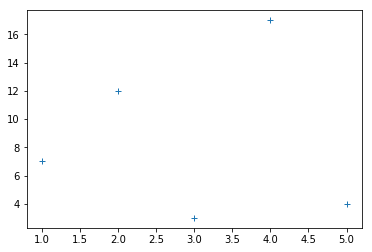

In [17]:
# Example de création de graphique avec matplotlib
x = [1, 2, 3, 4, 5]
y = [7, 12, 3, 17, 4]

plt.plot(x, y, "+")
plt.show()

<font color=orange>**Question** : *Combien de photos prennent les photographes de ce jeu de données ? Afficher la distribution du nombre de photographes par nombre de photos.* </font>  
Le résultat devrait ressembler à l'image suivante:  
![Photographes par nombre de photos](photographes_par_photo.png)

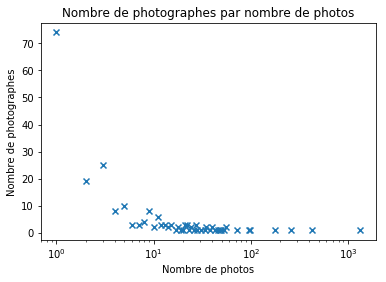

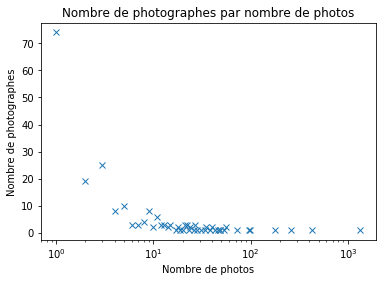

<font color=orange>**Question** : *Afficher un diagramme à barres de la distribution des photos sur les mois de l'année.* </font>  
Indication: la fonction matplotlib à utiliser est `bar`, la fonction `hist` [n'est pas ce que vous cherchez](https://giphy.com/embed/fZyssFynWmQSc).

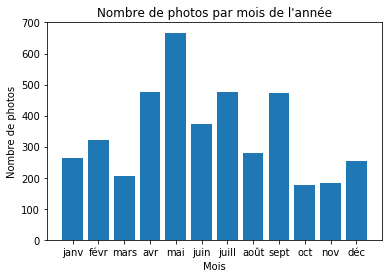

## Affichage des données sur une carte
Le code suivant permet d'afficher la position des photos sur une carte:

In [1]:
rennes_map = folium.Map(location = [LATITUDE, LONGITUDE], tiles="cartodbpositron", zoom_start = 12)

for row_nb, row in photos.iterrows():
    folium.CircleMarker([row["lat"], row["long"]], radius = 1).add_to(rennes_map)

# Alternativement, la boucle peut être remplacée par la ligne suivante (approche fonctionnelle) :
#photos.apply(lambda row: folium.CircleMarker([row["lat"], row["long"]], radius = 1).add_to(rennes_map), axis = 1)

# La ligne suivante permet d'enregistrer la carte
#rennes_map.save("rennes_map.html")

rennes_map

NameError: name 'folium' is not defined

## Limitation de l'effet "album photo"

Certains utilisateurs publient des séries de photos, généralemment prises au même endroit, dans un court laps de temps (quelques minutes). Par exemple : un utilisateur qui prend (et publie sur Flickr) plusieurs photos de son chat à son domicile. Il est évident que cet album photo, bien que le nombre de photos soit "conséquent", ne représente pas un point d'intérêt.  
Un centre d’intérêt doit être le lieu de photographies d’un grand nombre d’utilisateurs distincts et non pas d’une personne isolée.

Il est nécéssaire de traiter les données afin d'éliminer, ou du moins réduire, ce phénomène.  
Une solution, très simpliste, est de ne garder dans notre analyse qu'une photo par utilisateur par heure de temps.

<font color=orange>**Question** : *Donnez l'instruction pandas correspondante et critiquez-la. Mettez ensuite à jour le DataFrame photos en gardant une seule photo par groupe.*  </font> 
Indication : utiliser la méthode `groupby` avec plusieurs groupements.  
Note: passer le parametre `as_index = False` à la fonction pour éviter la création d'un index multiple.

<font color=orange>**Question** : *Affichez le DataFrame modifié*</font>

id_photographer  date_taken_year  date_taken_month  date_taken_day  \
0      100074746@N06             2018                 3               1   
1      100293696@N06             2018                 7               9   
2      101183566@N06             2017                 8              23   
3      103978073@N07             2018                 1              27   
4      103978073@N07             2018                 1              27   
5      103978073@N07             2018                 4              13   
6      103978073@N07             2018                 4              14   
7      105639886@N08             2017                 7              11   
8       10614518@N04             2016                12              24   
9      106785043@N02             2017                 6              12   
10     106785043@N02             2017                 7               3   
11     106785043@N02             2018                 4              17   
12     106785043@N02             2018                11              23   
13     107075798@N06             2017                 4              12   
14     107075798@N06             2017                 4              22   
15     107075798@N06             2017                 5               1   
16     107501344@N02             2018                 4               3   
17     108047436@N05             2018                 3              18   
18     108047436@N05             2018                 3              18   
19      11234074@N05             2018                 5              24   
20      11297120@N08             2017                10              18   
21     113111723@N02             2017                11               8   
22     113111723@N02             2017                11               8   
23     113111723@N02             2017                11               8   
24     115477150@N03             2018                 3              25   
25     119588793@N07             2017                 8               4   
26     119588793@N07             2017                 8              18   
27     119588793@N07             2017                 8              18   
28     119588793@N07             2017                 9               2   
29     119588793@N07             2017                 9              23   
...              ...              ...               ...             ...   
1202    92498591@N03             2018                 3              25   
1203    92498591@N03             2018                 3              25   
1204    92498591@N03             2018                 3              28   
1205    92498591@N03             2018                 7               5   
1206    92498591@N03             2018                 7               5   
1207    92498591@N03             2018                 8               5   
1208    92498591@N03             2018                 8              10   
1209    92498591@N03             2018                 8              29   
1210    92498591@N03             2018                 9              21   
1211    92498591@N03             2018                 9              26   
1212    92498591@N03             2018                 9              28   
1213     9308488@N05             2018                12              29   
1214     9308488@N05             2018                12              29   
1215    93641705@N07             2018                 2              23   
1216    93971071@N00             2017                 5              24   
1217    94453040@N08             2018                 5              16   
1218    94453040@N08             2018                 5              16   
1219    95019058@N03             2017                 8               9   
1220    95365623@N06             2017                 8               6   
1221    95366699@N05             2017                 6               8   
1222    95366699@N05             2017                 7              15   
1223    95366699@N05          

<font color=orange>**Question** : *Affichez le nombre de photos contenues dans le DataFrame.*</font>

1232

<font color=orange>**Question** : *Affichez les photos du DataFrame sur une carte.*</font>

# <font color=blue>Etape 2 : Clustering des photos</font>

## Rappel sur le clustering

Le clustering est une technique permettant de classer un ensemble d’objets (observations) par groupes appelés clusters ou classes. L’idée d’une méthode de clustering est généralement de maximiser la similarité des observations à l’intérieur d’un même cluster et de minimiser la similarité entre deux objets de clusters distincts.


Il existe un grand nombre d’algorithmes de clustering, parmi lesquels se trouvent KMeans et DBSCAN que l’on comparera par la suite.

### KMeans
Cet algorithme permet de grouper l’ensemble d’un « dataset » et donc de former des clusters. 
« Means » veut dire moyennes, l’algorithme KMeans identifie k points représentatifs, appelés moyennes, auxquels sont associés ensuite les autres points du jeu de données en fonction de leur proximité avec ces moyennes.

**Avantages** : KMeans est un algorithme très rapide, de complexité linéaire par rapport aux données. Il peut donc traiter de très grandes bases. Il n’y a pas de calcul de distance entre deux observations (2 à 2) à calculer, ce qui va à son avantage.

**Inconvénients** : KMeans a besoin en entrée du nombre de classes (clusters) K. Lorsque l’on souhaite analyser un dataset, nous ne connaissons pas toujours à l’avance ce nombre.
De plus, plusieurs exécutions de l’algorithme peuvent ne pas donner le même résultat en fonction de l’initialisation.

### DBSCAN

DBSCAN pour « Density-Based Spatial Clustering of Applications with Noise » est un algorithme de clustering basé 
sur la densité, dont le but est d’identifier, dans l’espace, les zones de forte densité. 
Celles-ci sont entourées de zones à faible densité que l’on appelle le bruit (d’où le « with Noise » dans le nom). 
L’intérêt est d’extraire les groupes à forte densité afin d’en découvrir des connaissances (centres d’intérêts).

DBSCAN a une complexité en O(n ∗ log(n)). Il est basé sur la densité. 
Il n’a pas besoin que l’on lui indique le nombre de clusters à identifier. Les seuls arguments dont il a besoin sont :

- epsilon : la distance maximale que doit avoir un point a avec un point b appartenant à un cluster pour prétendre en faire partie également.
- minPts : le nombre de points minimum pour qu’un groupe de points puisse être identifié comme un cluster


**Avantages** : DBSCAN permet d’éliminer le bruit de la classification et donc d’ignorer les valeurs aberrantes (outliers). Les clusters à base de densité, comme ceux produits par DBSCAN ne suivent pas un modèle de forme particulier. Il suffit d’un ensemble de points toujours liés par une distance inférieure à epsilon pour qu’il soit identifié comme un cluster (à condition que cet ensemble contient au moins minPts).  
Par exemple, dans le cadre de notre projet, nous pouvons imaginer un cluster de photos qui longe une rivière sur plusieurs kilomètres. Nous pouvons également imaginer un cluster qui entoure entièrement un autre cluster avec cet algorithme (cf. figure ci-dessous).


**Limite** : DBSCAN s’applique à des données « homogènes » par leur répartition et leur densité. Il ne permet de traiter qu’un type de densités à la fois.

### KMeans vs DBSCAN
![kmeans vs dbscan](kmeans_vs_dbscan.png)

**Clusters de forme convexe** : KMeans est une méthode qui se base sur des centroïdes. Les clusters détiennent les observations qui sont proches de leurs centres. Nous pouvons voir sur la figure ci-dessus — qui illustre le comportement de KMeans et de DBSCAN pour deux types de datasets différents — que KMeans distribue des clusters convexes autour des centres. Si l’on prend deux points quelconques d’un cluster convexe, le segment entre ces deux points appartiendra à la droite. C’est la définition d’une forme convexe (cf. définition d’un polygone convexe). Un cercle, un losange, une ellipse sont toutes des formes convexes.

**Clusters de forme non convexe (concave)** : DBSCAN, peut fournir des clusters concaves. Une demie lune est une forme concave : si l’on prend deux points aux extrémités de la demie lune, le segment qui les lie sort de la forme en question.

## Identification des points d'intérêt

<font color=orange>**Question** : *Choisissez un algorithme pour notre problème parmi ces 2 algorithmes en justifiant votre choix.*</font>

*Réponse :*

<font color=orange>**Question** : *Appliquez l'algorithme sur les données en utilisant soit `sklearn.cluster.KMeans` ou `sklearn.cluster.DBSCAN`*</font>

Vous pouvez afficher l'aide python (contenant des exemples d'utilisation) sur ces algorithmes avec la fonction`help(nom_complet_algorithme)`

Paramètres conseillés:
- Pour KMeans: 
    - `n_clusters` : à vous de le déterminer
- Pour DBSCAN:
    - `eps` : 0.00030
    - `min_samples` : 7

In [26]:
help(sklearn.cluster.KMeans)
help(sklearn.cluster.DBSCAN)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'} or ndarray of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization, defaults to 'k-means++':
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose k observations (rows) at random from data for
 |      the initial centroids.
 |  
 |      If an ndarray is passed, it should be of shape (n_clusters, n_features)
 |      and gives the initial centers.
 |  
 

In [27]:
dbscan = sklearn.cluster.DBSCAN(eps = 0.00030, min_samples = 7).fit(photos[["lat", "long"]])

<font color=orange>**Question** : *Affichez la liste des labels des clusters crées*</font>  
Vous devez obtenir un tableau qui indique le numéro de cluster de chaque photo, comme celui-ci : array([-1, -1, -1, ..., -1, -1, -1])

array([-1, -1, -1, ..., -1, -1, -1])

<font color=orange>**Question** : *Ajoutez ces informations au DataFrame, dans une nouvelle colonne "cluster". Affichez le DataFrame.*</font>

id_photographer  date_taken_year  date_taken_month  date_taken_day  \
0      100074746@N06             2018                 3               1   
1      100293696@N06             2018                 7               9   
2      101183566@N06             2017                 8              23   
3      103978073@N07             2018                 1              27   
4      103978073@N07             2018                 1              27   
5      103978073@N07             2018                 4              13   
6      103978073@N07             2018                 4              14   
7      105639886@N08             2017                 7              11   
8       10614518@N04             2016                12              24   
9      106785043@N02             2017                 6              12   
10     106785043@N02             2017                 7               3   
11     106785043@N02             2018                 4              17   
12     106785043@N02             2018                11              23   
13     107075798@N06             2017                 4              12   
14     107075798@N06             2017                 4              22   
15     107075798@N06             2017                 5               1   
16     107501344@N02             2018                 4               3   
17     108047436@N05             2018                 3              18   
18     108047436@N05             2018                 3              18   
19      11234074@N05             2018                 5              24   
20      11297120@N08             2017                10              18   
21     113111723@N02             2017                11               8   
22     113111723@N02             2017                11               8   
23     113111723@N02             2017                11               8   
24     115477150@N03             2018                 3              25   
25     119588793@N07             2017                 8               4   
26     119588793@N07             2017                 8              18   
27     119588793@N07             2017                 8              18   
28     119588793@N07             2017                 9               2   
29     119588793@N07             2017                 9              23   
...              ...              ...               ...             ...   
1202    92498591@N03             2018                 3              25   
1203    92498591@N03             2018                 3              25   
1204    92498591@N03             2018                 3              28   
1205    92498591@N03             2018                 7               5   
1206    92498591@N03             2018                 7               5   
1207    92498591@N03             2018                 8               5   
1208    92498591@N03             2018                 8              10   
1209    92498591@N03             2018                 8              29   
1210    92498591@N03             2018                 9              21   
1211    92498591@N03             2018                 9              26   
1212    92498591@N03             2018                 9              28   
1213     9308488@N05             2018                12              29   
1214     9308488@N05             2018                12              29   
1215    93641705@N07             2018                 2              23   
1216    93971071@N00             2017                 5              24   
1217    94453040@N08             2018                 5              16   
1218    94453040@N08             2018                 5              16   
1219    95019058@N03             2017                 8               9   
1220    95365623@N06             2017                 8               6   
1221    95366699@N05             2017                 6               8   
1222    95366699@N05             2017                 7              15   
1223    95366699@N05          

<font color=orange>**Question** : *Affichez la liste des labels de cluster du DataFrame, sans les doublons. Quel label est utilisé pour marquer une photo qui n'appartient pas à un cluster ?*</font>

array([-1,  0, 14,  1,  6,  2,  3,  7,  4,  5,  8,  9, 10, 11, 12, 13, 15,
       16, 17, 18, 19])

<font color=orange>**Question** : *Affichez les url de toutes les photos appartenant au cluster de label 2.*</font>

array(['https://www.flickr.com/photos/119588793@N07/36609063310/',
       'https://www.flickr.com/photos/nathph/44843668934/',
       'https://www.flickr.com/photos/nathph/46056069072/',
       'https://www.flickr.com/photos/nathph/31267284097/',
       'https://www.flickr.com/photos/nathph/46357262171/',
       'https://www.flickr.com/photos/127653448@N08/36132734214/',
       'https://www.flickr.com/photos/131283788@N04/29760333648/',
       'https://www.flickr.com/photos/131283788@N04/29760329228/',
       'https://www.flickr.com/photos/brunovanbesien/27319878279/',
       'https://www.flickr.com/photos/soujirou/34977404014/',
       'https://www.flickr.com/photos/soujirou/34977653444/',
       'https://www.flickr.com/photos/philippemanguin/39871198251/',
       'https://www.flickr.com/photos/anubisbastet/44142268135/',
       'https://www.flickr.com/photos/lavilleautady/33546104433/'],
      dtype=object)

## Affichage sur une carte
Nous voulons maintenant afficher les clusters sur une carte.

Nous vous fournissons une fonction qui permet d'associer une couleur à un label.

In [32]:
#COLORS = ["red", "blue", "green", "purple", "orange", "darkred", "lightred", "darkblue", "darkgreen", "cadetblue", "pink", "lightblue", "lightgreen", "gray", "black"]
COLORS = ['darkpurple', 'cadetblue', 'orange', 'purple', 'lightred', 'darkblue', 'pink', 'green', 'lightblue', 'blue', 'darkgreen', 'lightgreen', 'gray', 'red', 'lightgrayblack', 'darkred', 'beige']
def get_color(label):
    if label < 0: # Bruit
        return "lightgray"
    else:
        return COLORS[label % len(COLORS)]



<font color=orange>**Question** : *Affichez les photos sur une carte, avec pour chaque photo une couleur correspondante au cluster dont elle fait partie.*</font>

Nous voulons rendre les clusters plus visibles. Pour cela nous allons créer un `folium.Marker` par cluster.

<font color=orange>**Question** : *Modifiez la question précédente pour ajouter un marqueur par cluster (au milieu de préférence) , de la bonne couleur et avec un texte indiquant le label du cluster.*</font>

## Question(s) bonus
S'il vous reste du temps, vous pouvez essayer de jouer sur les paramètres de clustering pour avoir des clusters qui correspondent à votre idée de point d’intérêt de Rennes, ajouter un lien vers une photo du cluster dans les popups, etc.


# <font color=blue>Etape 3 : Caractérisation des clusters</font>


Au delà des descripteurs spatiaux (latitude et longitude), les tags des photos sont fournis. Bien que renseignés par l’utilisateur, ils peuvent être source d’informations supplémentaires à propos du lieu de prise de la photo. Ils pourraient également permettre de caractériser les classes/clusters/groupes de photos, i.e. les points d’intérêt. 
<br>
<br>
    La solution est d’utiliser les informations de chaque photo, en particulier ses tags.
    
<!--La Table 4 représente les tags les plus représentatifs pour quelques clusters de notre étude. En d’autres termes elle illustre des exemples de points d’intérêt de Rennes caractérisés par les tags de leurs photos. Ceci est un extrait de ce qui devrait être obtenu à l’issue de cette partie.  
  
IMAGE A AJOUTER-->

## Prétraitement et nettoyage des tags

La fonction supprimeIdentPhoto supprime des tags identifiés comme non pertinents (commencant par "img" ou "dsc").

In [35]:
def supprimeIdentPhoto(tag):
    regex1 = re.compile(r"^img_")
    regex2 = re.compile(r"^dsc_")
    tag2 = ' '.join([word for word in tag.split() if (regex1.match(word) or regex2.match(word)) is None])
    return tag2

#supprimeIdentPhoto("IMG_7719")
#supprimeIdentPhoto("DSC_2692.JPG")
#supprimeIdentPhoto("last summer vibes")

<font color=orange>**Question** : *Compléter la méthode lowerCase qui met en minuscules un ensemble de tags.*</font>


In [36]:

lowerCase("last Summer? Vibes")
# Résultat attendu : 'last summer? vibes'

'last summer? vibes'

<font color=orange>**Question** : *Compléter la méthode supprimeAccent qui enlève les accents des lettres accentuées.*</font>


In [37]:
accents = { 'a': ['à', 'ã', 'á', 'â'],
            'e': ['é', 'è', 'ê', 'ë'],
            'i': ['î', 'ï'],
            'u': ['ù', 'ü', 'û'],
            'o': ['ô', 'ö'] }



supprimeAccent("à rennes le marchédeslices")
# Resultat attendu : 'a rennes le marchedeslices'

'a rennes le marchedeslices'

<font color=orange>**Question** : *Compléter la méthode supprimeStopwords qui supprime les mots apparaissant dans la liste des mots vides du français `stopwordslist` (initialisée au début du TP).*</font>


In [38]:

supprimeStopwords("rennes le marchédeslices")
# Résultat attendu : 'rennes marchédeslices'

'rennes marchédeslices'

<font color=orange>**Question** : *Sélectionner ensuite seulement ceux étant alpha-numériques et pouvant contenir des traits d’union et des tirets bas (élimination de tous les tags comportant d’autres caractères spéciaux). Cette sélection peut se faire grâce au module re de Python.*</font>

In [39]:

supprimeCarSpeciaux("last Summer? Vibes-one")
# Résultat attendu : 'last Vibes-one'

'last Vibes-one'

Une fois toutes les fonctions bien définies, elles sont utilisées pour traiter les tags des photos, ci-dessous.

In [40]:
# Traitement des tags
photos["tags"] = photos["tags"].fillna("") 
tagsApres=[]
for row_nb, row in photos.iterrows():
    tags = row["tags"]
    t0 = lowerCase(tags)
    t1 = supprimeAccent(t0)
    t2 = supprimeStopwords(t1)
    t3 = supprimeIdentPhoto(t2)
    t4 = supprimeCarSpeciaux(t3)
    tagsApres.append(t4)
photos["tags"]=tagsApres


photos


id_photographer  date_taken_year  date_taken_month  date_taken_day  \
0      100074746@N06             2018                 3               1   
1      100293696@N06             2018                 7               9   
2      101183566@N06             2017                 8              23   
3      103978073@N07             2018                 1              27   
4      103978073@N07             2018                 1              27   
5      103978073@N07             2018                 4              13   
6      103978073@N07             2018                 4              14   
7      105639886@N08             2017                 7              11   
8       10614518@N04             2016                12              24   
9      106785043@N02             2017                 6              12   
10     106785043@N02             2017                 7               3   
11     106785043@N02             2018                 4              17   
12     106785043@N02             2018                11              23   
13     107075798@N06             2017                 4              12   
14     107075798@N06             2017                 4              22   
15     107075798@N06             2017                 5               1   
16     107501344@N02             2018                 4               3   
17     108047436@N05             2018                 3              18   
18     108047436@N05             2018                 3              18   
19      11234074@N05             2018                 5              24   
20      11297120@N08             2017                10              18   
21     113111723@N02             2017                11               8   
22     113111723@N02             2017                11               8   
23     113111723@N02             2017                11               8   
24     115477150@N03             2018                 3              25   
25     119588793@N07             2017                 8               4   
26     119588793@N07             2017                 8              18   
27     119588793@N07             2017                 8              18   
28     119588793@N07             2017                 9               2   
29     119588793@N07             2017                 9              23   
...              ...              ...               ...             ...   
1202    92498591@N03             2018                 3              25   
1203    92498591@N03             2018                 3              25   
1204    92498591@N03             2018                 3              28   
1205    92498591@N03             2018                 7               5   
1206    92498591@N03             2018                 7               5   
1207    92498591@N03             2018                 8               5   
1208    92498591@N03             2018                 8              10   
1209    92498591@N03             2018                 8              29   
1210    92498591@N03             2018                 9              21   
1211    92498591@N03             2018                 9              26   
1212    92498591@N03             2018                 9              28   
1213     9308488@N05             2018                12              29   
1214     9308488@N05             2018                12              29   
1215    93641705@N07             2018                 2              23   
1216    93971071@N00             2017                 5              24   
1217    94453040@N08             2018                 5              16   
1218    94453040@N08             2018                 5              16   
1219    95019058@N03             2017                 8               9   
1220    95365623@N06             2017                 8               6   
1221    95366699@N05             2017                 6               8   
1222    95366699@N05             2017                 7              15   
1223    95366699@N05          

## Analyse des tags associés

### Exemple d'utilisation de l'algorithme Apriori

Ci-dessous, nous vous donnons un exemple d'utilisation de l'algorithme Apriori vu en cours pour extraire les itemsets fréquents.

In [41]:
# Intialisation du jeu de données sous la forme d'un tableau de tableaux
dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]
dataset

[['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
 ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
 ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
 ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
 ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]

In [42]:
# Transformation des données en dataframe
from mlxtend.preprocessing import TransactionEncoder

t_encoder = TransactionEncoder()
t_array = t_encoder.fit(dataset).transform(dataset)
df = pd.DataFrame(t_array, columns = t_encoder.columns_)
df

Apple   Corn   Dill   Eggs  Ice cream  Kidney Beans   Milk  Nutmeg  Onion  \
0  False  False  False   True      False          True   True    True   True   
1  False  False   True   True      False          True  False    True   True   
2   True  False  False   True      False          True   True   False  False   
3  False   True  False  False      False          True   True   False  False   
4  False   True  False   True       True          True  False   False   True   

   Unicorn  Yogurt  
0    False    True  
1    False    True  
2    False   False  
3     True    True  
4    False   False

In [43]:
# Application d'Apriori avec minsup=60% sur le dataframe
frequent_itemsets = apriori(df, min_support = 0.6, use_colnames = True)
frequent_itemsets

support                     itemsets
0       0.8                       (Eggs)
1       1.0               (Kidney Beans)
2       0.6                       (Milk)
3       0.6                      (Onion)
4       0.6                     (Yogurt)
5       0.8         (Eggs, Kidney Beans)
6       0.6                (Onion, Eggs)
7       0.6         (Milk, Kidney Beans)
8       0.6        (Onion, Kidney Beans)
9       0.6       (Yogurt, Kidney Beans)
10      0.6  (Onion, Eggs, Kidney Beans)

In [44]:
# Comptage du nombre d'items par itemset
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

support                     itemsets  length
0       0.8                       (Eggs)       1
1       1.0               (Kidney Beans)       1
2       0.6                       (Milk)       1
3       0.6                      (Onion)       1
4       0.6                     (Yogurt)       1
5       0.8         (Eggs, Kidney Beans)       2
6       0.6                (Onion, Eggs)       2
7       0.6         (Milk, Kidney Beans)       2
8       0.6        (Onion, Kidney Beans)       2
9       0.6       (Yogurt, Kidney Beans)       2
10      0.6  (Onion, Eggs, Kidney Beans)       3

### Extraction des mots fréquents par cluster

Dans cette partie, on va extraire les itemsets fréquents des tags de chaque cluster et choisir l'itemset le plus fréquent et le plus long comme étiquette de ce cluster.

In [45]:
# Construction d'une table de hachage qui associe à chaque numéro de cluster une étiquette "no label"
cluster_labels = {}
for cluster in photos["cluster"].unique():
    cluster_labels[cluster] = "no label"
cluster_labels

{-1: 'no label',
 0: 'no label',
 1: 'no label',
 2: 'no label',
 3: 'no label',
 4: 'no label',
 5: 'no label',
 6: 'no label',
 7: 'no label',
 8: 'no label',
 9: 'no label',
 10: 'no label',
 11: 'no label',
 12: 'no label',
 13: 'no label',
 14: 'no label',
 15: 'no label',
 16: 'no label',
 17: 'no label',
 18: 'no label',
 19: 'no label'}

<font color=orange>**Question** : *Pour chaque cluster extraire les itemsets fréquents afin de déterminer une étiquette par cluster.*
</font>  
Indication : Pour chaque cluster :   
1. calculer les motifs fréquents de longueur (nombre d'items) au moins 2,  
1. les trier par support puis par longueur,  
1. ne garder que le plus fréquent, 
1. associer ce motif comme étiquette au cluster dans la table de hachage.

Note : C'est à vous de jouer sur le seuil de support (minsup) pour observer à quel moment vous obtenez quelque chose d'intéressant.

In [46]:
def identify_cluster(cluster_nb):
    # Création d'une liste de listes contenant les tags du cluster
    cluster_tags = []
    for row_nb, row in photos[photos["cluster"] == cluster_nb].iterrows():
        cluster_tags.append(row["tags"].split())
    #print(cluster_tags)
    
    # Transformation des données en dataframe
    t_encoder = TransactionEncoder()
    t_array = t_encoder.fit(cluster_tags).transform(cluster_tags)
    cluster_tags_transactions = pd.DataFrame(t_array, columns = t_encoder.columns_)
    #print(cluster_tags_transactions.head())
    
    # Application d'Apriori avec minsup=15% sur le dataframe
    frequent_itemsets = apriori(cluster_tags_transactions, min_support = 0.15, use_colnames = True)
    #print(frequent_itemsets.head())
    
    # Comptage du nombre d'items par itemset
    frequent_itemsets["length"] = frequent_itemsets["itemsets"].apply(lambda x: len(x))
    #print(frequent_itemsets)
    
    # Filtrage des motifs avec longueur >= 2
    frequent_itemsets = frequent_itemsets[frequent_itemsets["length"] >= 2]
    #print(frequent_itemsets)
    
    # Tri par support puis par longueur
    frequent_itemsets.sort_values(by = ["support", "length"], ascending = False, inplace = True)
    #print(frequent_itemsets)
    
    # Itemset le plus fréquent
    most_frequent_itemset = frequent_itemsets["itemsets"][0:1]
    #print(most_frequent_itemset)
    
    # Construction d'une étiquette à partir des items de l'itemset
    label = ""
    if len(most_frequent_itemset.values) >= 1:
        for tag in most_frequent_itemset.values[0]:
            label += tag + " "
    else:
        label = "no label"
    #print(label)
    
    # Association du label au cluster
    cluster_labels[cluster_nb] = label

for cluster_nb in cluster_labels:
    identify_cluster(cluster_nb)

<font color=orange>**Question** : *Associer le cluster et son étiquette dans l'affichage avec la carte.*
</font>  


In [47]:
rennes_map = folium.Map(location = [LATITUDE, LONGITUDE], tiles="cartodbpositron", zoom_start = 12)

for row_nb, row in photos.iterrows():
    folium.CircleMarker([row["lat"], row["long"]], radius = 1, color = get_color(row["cluster"])).add_to(rennes_map)

for cluster, row in photos.groupby("cluster").mean().iterrows():
    if cluster >= 0:
        popupText = "Cluster {}: {}".format(cluster, cluster_labels[cluster])
        folium.Marker([row["lat"], row["long"]], icon = folium.Icon(color = get_color(cluster)), popup = popupText).add_to(rennes_map)
    
rennes_map